In [1]:
#Import list
%load_ext autoreload
%autoreload 2
import warnings
import xlsxwriter
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import Generative_model
from scipy import stats
import pandas as pd
from entropy_weirdshiz import Calculate_entropy_2 as EC_2

#all pymc3 requirement
import pymc3 as pm
import theano.tensor as tt
import theano as th
import arviz as az

from pymc3 import Model, Normal, Slice, sample, Uniform, Binomial, HalfNormal
from pymc3.distributions import Interpolated



plt.style.use("seaborn-darkgrid")
print(f"Running on PyMC3 v{pm.__version__}")

Imports successful
test
Imports successful
Entropy calculated: [3.00000150e-06 3.00000150e-06 3.00000150e-06 3.00000150e-06
 3.00000150e-06 3.00000150e-06 3.00000100e-06 5.69073410e-05
 4.01768194e-02 8.83097532e-01 1.30977830e+00 8.83097532e-01
 4.01768194e-02 5.69073410e-05 3.00000100e-06 3.00000150e-06
 3.00000150e-06]


c:\Users\herma\OneDrive\Documenten\university\University_year_4\Semester_2\thesis\Thesis\entropy_weirdshiz.py:48: RuntimeWarning: divide by zero encountered in log
  log_param_theta_ccw =  np.clip(np.log(param_theta_ccw), 1e-6, None)
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC3 v3.11.5


C:\Users\herma\AppData\Local\Temp\ipykernel_28732\847425566.py:25: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-darkgrid")


### Data generation

In [2]:
#the start values with the true value of mu and sigma 
mu,sigma = 1,2
#number of samples used per iteration
n_samples = 1
n_samples_per_degree = np.zeros(17)
#the total range of stimuli in the model 
stimuli = np.arange(-8,9)
#initialise dataset 
data_set = np.zeros(17)

#Function to generate samples
#The function will add the results to the previous data set
# it will also add the total samples used per degree to a list called n_samples_per_degree
def generate_samples(mu,sigma,n_samples,n_samples_per_degree,degree,data_set):
    #create normal distribution
    normal_dist = stats.norm(loc = mu, scale=sigma)
    #sample data given amount of samples and distribution
    responses = np.random.binomial(n_samples,p=normal_dist.cdf(degree))
    #add responses to data set with +8 shift to account for degrees 
    data_set[degree+8] += responses
    #add amount of samples to n_samples_per_degree
    n_samples_per_degree[degree+8] += n_samples
    #return file
    return data_set,n_samples_per_degree
    




##### random sampling

In [3]:
#a function that uses random function to use the generate sample function to produce a random sample. 
def random_response(n_samples_per_degree_random,data_set_random):
    random_point = (int(np.random.uniform(-9,9,1)))
    samples = generate_samples(mu,sigma,1,n_samples_per_degree_random,random_point,data_set_random)
    return samples[0],samples[1], random_point


### Set up of the model

In [4]:

#this function calculates a cumulative densistiy function based on a given mean and std. This is used to convert the input variables.
def cumulative_normal(x, mean, sigma, s=np.sqrt(2)):
    # Cumulative distribution function for the standard normal distribution
    return 0.5 + 0.5 * tt.erf((x-mean)/(sigma*s))

Initialisation of the model: 
This code block below sets up the model used using a uniform distribution for the mean and a gamma distribution for the std as priors. 
This model will be refitted later down the line when more data is generated

c:\Users\herma\anaconda3\envs\pymc3_env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mn]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 33 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.
c:\Users\herma\anaconda3\envs\pymc3_env\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
c:\Users\herma\anaconda3\envs\pymc3_env\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_

0.721 1.929


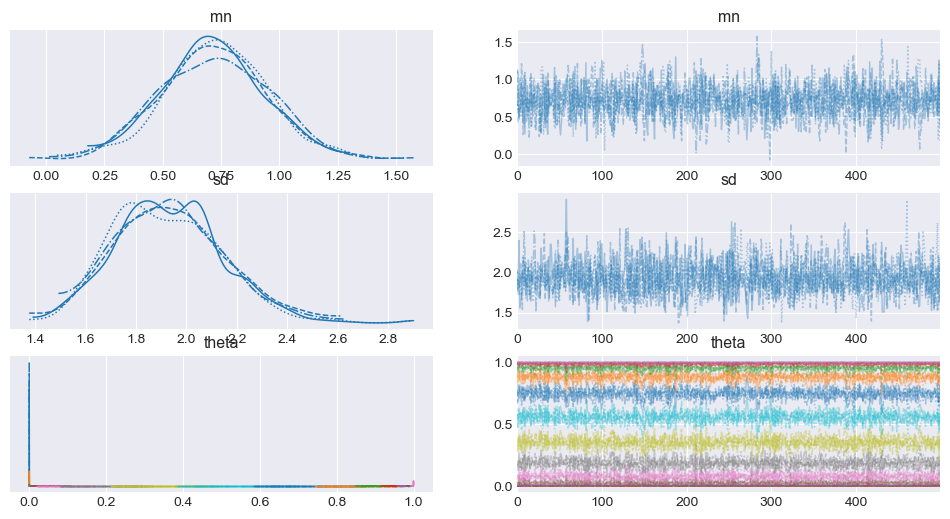

In [7]:
model_cdf = pm.Model()
for i in range(-8,9):
    data_set,n_samples_per_degree= generate_samples(mu,sigma,20,n_samples_per_degree,i,data_set)
with model_cdf:
    curve_mean = pm.Uniform('mn', lower=-8, upper =8)#pm.Normal("curve_mu",mu=0,sigma=5)
    curve_std =pm.Gamma("sd",alpha=3,beta=1)#pm.HalfNormal("curve_sigma",sigma=1.5)

    #calculate the cdfs of the means and std to fit onto the observations. 
    theta = pm.Deterministic('theta', cumulative_normal(stimuli,curve_mean,curve_std))
    Y_obs = pm.Binomial("Y_obs", n=n_samples_per_degree, p=theta, observed=data_set)
    model_trace = pm.sample(500, cores=4)  # Sampling from the model
az.plot_trace(model_trace)   
df_0 = az.summary(model_trace)
mean_value_0 = df_0.loc["mn", "mean"]
sd_value_0 = df_0.loc["sd", "mean"]
print(mean_value_0,sd_value_0)

In [16]:

#generate new sample based on stimulus
def add_data(n_samples_per_degree,data_set,counter,proposed_stimulus,sample_amount):
    new_data_set,n_samples_per_degree = generate_samples(mu,sigma,sample_amount,n_samples_per_degree,proposed_stimulus,data_set)
    with model_cdf:
        #fit the new data to the observations
        Y_obs = pm.Binomial("Y_obs"+str(counter), n=n_samples_per_degree, p=theta, observed=new_data_set)
        #trace the posterior
        model_trace = pm.sample(100, cores=4)  # Sampling from the model
    return model_trace




### entropy calculations


In [8]:
#function to calculate entropy
def Calculate_entropy(lambda_list, theta):
    # Initialize lists
    # Probability of clockwise
    pcw = np.zeros(len(theta))
    # Probability of counter clockwise
    pccw = np.zeros(len(theta))  # Corrected to create a new zero array instead of sharing the reference

    # The dimensions of the input lambdas 
    dimensions_lambda = np.shape(lambda_list)
    
    # Initialization of empty list for the probability of a given lambda with a given theta being clockwise
    param_theta_cw = np.zeros((dimensions_lambda[0], len(theta)))
    param_theta_ccw = np.zeros((dimensions_lambda[0], len(theta)))  # Corrected to create a new zero array instead of sharing the reference

    # Go over all theta values
    for idx, theta_val in enumerate(theta):     
        Pcw_theta_lambda = []
        for lamb in lambda_list:
            # Given a specific lambda and degree (theta) clockwise probability
            Pcw_theta_lambda.append(stats.norm.cdf(theta_val, lamb[0], lamb[1]))
        # What is the total probability of clockwise for this degree (theta) 
        pcw[idx] = sum(Pcw_theta_lambda) / dimensions_lambda[0]
        # Probability counterclockwise
        pccw[idx] = 1 - pcw[idx]

    # Clip lists to avoid NaN
    pcw = np.clip(pcw, 1e-6, 1 - 1e-6)
    pccw = np.clip(pccw, 1e-6, 1 - 1e-6)

    # For each parameter pair
    for lamb_idx, lamb in enumerate(lambda_list):      # does this just calculate the mean? 
        # For each theta_val
        for idx, theta_val in enumerate(theta):
            # Find given probability
            p_cw = stats.norm.cdf(theta_val, lamb[0], lamb[1])
            p_ccw = 1 - p_cw
            #Calculate probability of a lambda given theta and direction (cw or ccw)
            param_theta_cw[lamb_idx, idx] = p_cw / pcw[idx]
            param_theta_ccw[lamb_idx, idx] = p_ccw / pccw[idx]

    # Calculate the log value of the probabilities
    # Clip is included to avoid NaN values
    log_param_theta_cw = np.log(np.clip(param_theta_cw, 1e-6, None))
    log_param_theta_ccw = np.log(np.clip(param_theta_ccw, 1e-6, None))

    # Calculate individual multiplications
    pre_sum_cw = log_param_theta_cw * param_theta_cw
    pre_sum_ccw = log_param_theta_ccw * param_theta_ccw
    # Calculate H (entropy component for cw and ccw)
    H_cw = np.sum(pre_sum_cw, axis=0)
    H_ccw = np.sum(pre_sum_ccw, axis=0)

    # Entropy calculation
    entropy = H_cw * pcw + H_ccw * pccw
    return entropy,(np.argmax(entropy)-8)

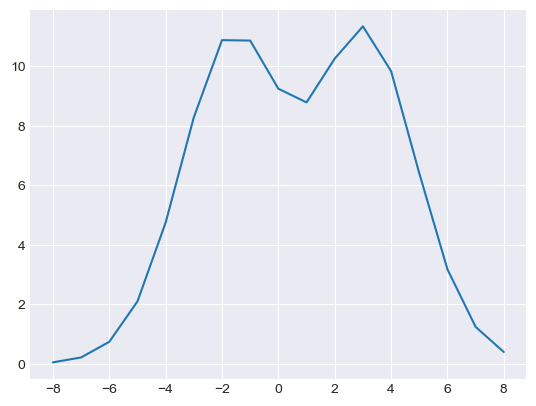

In [11]:
#extract posterior mu and sigma samples to a list
lambda_list = [(model_trace["mn"][i],model_trace["sd"][i]) for i in range(len(model_trace["sd"]))]
# mu_mean = np.mean(model_trace["mn"])
# sd_mean = np.mean(model_trace["sd"])
e_1,stim = Calculate_entropy(lambda_list,stimuli)

#problem with finding the right stimulus since it seems to be an inverse?
plt.plot(stimuli,e_1)

### Display model estimation

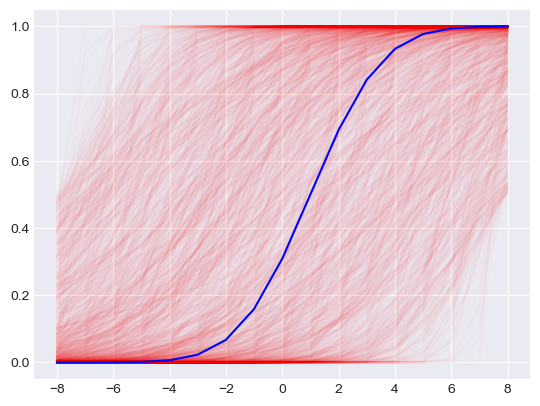

In [ ]:
def plot_model(lambda_list):
    #generate plots of all mu sigma pairs
    x = range(-8,9)
    #for each lambda pair in the posterior
    for i in lambda_list:
        #plot the line with a 0.01 opacity to ensure viewability
        plt.plot(x,stats.norm(loc = i[0], scale=i[1]).cdf(x),alpha=0.01,color="r")
    #plot ground truth
    plt.plot(x,stats.norm(loc = mu, scale=sigma).cdf(x),color="b")

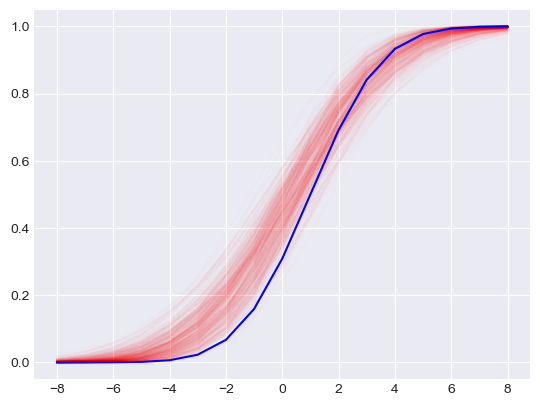

In [77]:
#generate plots of all mu sigma pairs
x = range(-8,9)
#for each lambda pair in the posterior
for i in lambda_list:
    #plot the line with a 0.01 opacity to ensure viewability
    plt.plot(x,stats.norm(loc = i[0], scale=i[1]).cdf(x),alpha=0.01,color="r")
#plot ground truth
plt.plot(x,stats.norm(loc = mu, scale=sigma).cdf(x),color="b")

In [21]:
#ground truth
mu = 1
sigma = 2
#set up the data:
#number of samples used per iteration
n_samples = 1


[ 0.  0.  0.  0.  0.  0.  0.  0. 34.  0.  0.  0.  0.  0.  0.  0.  0.]


# Adaptive sampling
these code blocks are about the loop for adaptive sampling. First it initialises a dataframe to store information about the entropy the mu mean and sigma after which a model is set up and looped until stopping criteria are met.


to add
save stimuli presented
save lambda list in df 
also only do 50 sets


In [18]:
 
column_names = ["Entropy_x " + str(i) for i in range(-8,9)]
column_names.append("mu")
column_names.append("sigma")
print(column_names)
data_frame_adaptive = pd.DataFrame(columns=column_names)



['Entropy_x -8', 'Entropy_x -7', 'Entropy_x -6', 'Entropy_x -5', 'Entropy_x -4', 'Entropy_x -3', 'Entropy_x -2', 'Entropy_x -1', 'Entropy_x 0', 'Entropy_x 1', 'Entropy_x 2', 'Entropy_x 3', 'Entropy_x 4', 'Entropy_x 5', 'Entropy_x 6', 'Entropy_x 7', 'Entropy_x 8', 'mu', 'sigma']


c:\Users\herma\anaconda3\envs\pymc3_env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mn]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 32 seconds.


proposed stim 0
itteration 1


c:\Users\herma\anaconda3\envs\pymc3_env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mn]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 32 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6883811242524689, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7089015405195448, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.


proposed stim 0
itteration 2


c:\Users\herma\anaconda3\envs\pymc3_env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mn]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 33 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
Got error No model on context stack. trying to find log_likelihood in translation.
c:\Users\herma\anaconda3\envs\pymc3_env\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


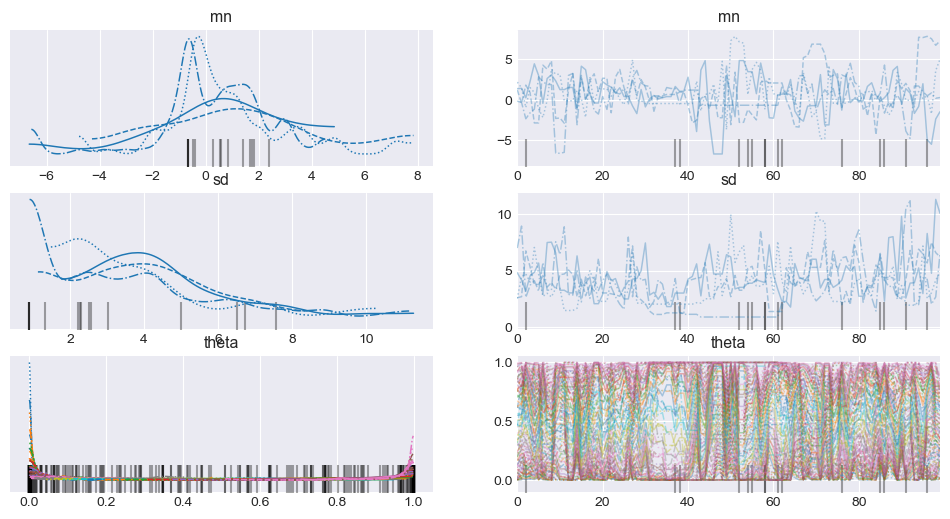

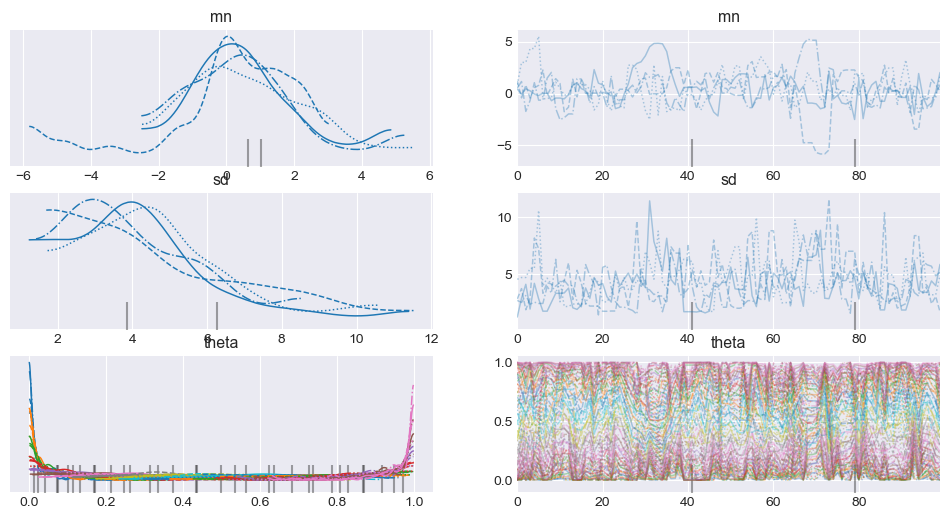

In [17]:
#voeg 1 sample per stimuli toe als start set. 


#setting up stopping criteria
criteria_met_random = False
criteria_met_adaptive = False


#sample count
n_samples_per_degree_adaptive = np.zeros(17)

#the total range of stimuli in the model 
stimuli = np.arange(-8,9)
#initialise dataset 
data_set_adaptive = np.zeros(17)


#set up the model:
model_cdf = pm.Model()

with model_cdf:
    curve_mean = pm.Uniform('mn', lower=-8, upper =8)#pm.Normal("curve_mu",mu=0,sigma=5)
    curve_std =pm.Gamma("sd",alpha=3,beta=1)#pm.HalfNormal("curve_sigma",sigma=1.5)

    #calculate the cdfs of the means and std to fit onto the observations. 
    theta = pm.Deterministic('theta', cumulative_normal(stimuli,curve_mean,curve_std))
    Y_obs = pm.Binomial("Y_obs", n=n_samples_per_degree_adaptive, p=theta, observed=data_set_adaptive)
    model_trace = pm.sample(500, cores=4)  # Sampling from the model
iteration_counter = 0
#while not criteria_met_adaptive:
while iteration_counter < 2:
    #check mean if criteria is met
    mu_mean = np.mean(model_trace["mn"])
    sd_mean = np.mean(model_trace["sd"])
    #check if the mu and sigma are within the hitting mark
    if  mu-0.05 <= mu_mean<= mu+0.05 and sigma-0.05 <= sd_mean<= sigma+0.05:
        criteria_met_adaptive = True
        break
    #extracting posterior samples
    lambda_list_adaptive = [(model_trace["mn"][i],model_trace["sd"][i]) for i in range(len(model_trace["sd"]))]
    #calculating entropy
    entropy,proposed_stim = Calculate_entropy(lambda_list_adaptive,stimuli)
    print("proposed stim " + str(proposed_stim))
    data_frame_adaptive.loc[iteration_counter] = entropy.tolist() + [mu_mean, sd_mean]
    #check itterations
    iteration_counter += 1
    print("itteration " + str(iteration_counter))
    #given 
    model_trace_temp = add_data(n_samples_per_degree_adaptive,data_set_adaptive,iteration_counter,proposed_stim,5)
    az.plot_trace(model_trace_temp)
    

    
     



### random sampling
This code blocks will concern itself with random sampling
First it initialises a dataframe for random sampling. It is similar to the adaptive data frame however it also saves the value that is picked by a rng to propose as stimulus.
after which it loops through the process of adaptive sampling

In [34]:
column_names = ["Entropy_x " + str(i) for i in range(-8,9)]
column_names.append("mu")
column_names.append("sigma")
column_names.append("stimulus_used")
print(column_names)
data_frame_random = pd.DataFrame(columns=column_names)

['Entropy_x -8', 'Entropy_x -7', 'Entropy_x -6', 'Entropy_x -5', 'Entropy_x -4', 'Entropy_x -3', 'Entropy_x -2', 'Entropy_x -1', 'Entropy_x 0', 'Entropy_x 1', 'Entropy_x 2', 'Entropy_x 3', 'Entropy_x 4', 'Entropy_x 5', 'Entropy_x 6', 'Entropy_x 7', 'Entropy_x 8', 'mu', 'sigma', 'stimulus_used']


In [38]:
#Initialise the model

iteration_counter = 0
#initialise the data set and sample set
n_samples_per_degree_random= np.zeros(17)
data_set_random  = np.zeros(17)

model_cdf = pm.Model()

with model_cdf:
    curve_mean = pm.Uniform('mn', lower=-8, upper =8)#pm.Normal("curve_mu",mu=0,sigma=5)
    curve_std =pm.Gamma("sd",alpha=3,beta=1)#pm.HalfNormal("curve_sigma",sigma=1.5)

    #calculate the cdfs of the means and std to fit onto the observations. 
    theta = pm.Deterministic('theta', cumulative_normal(stimuli,curve_mean,curve_std))
    Y_obs = pm.Binomial("Y_obs", n=n_samples_per_degree_adaptive, p=theta, observed=data_set_adaptive)
    model_trace = pm.sample(500, cores=4)  # Sampling from the model

    
while not criteria_met_random:
#while iteration_counter < 2:
    #check mean if criteria is met
    mu_mean = np.mean(model_trace["mn"])
    sd_mean = np.mean(model_trace["sd"])
    #check if the mu and sigma are within the hitting mark
    if  mu-0.05 <= mu_mean<= mu+0.05 and sigma-0.05 <= sd_mean<= sigma+0.05:
        criteria_met_random = True
        break
    
    #extracting posterior samples
    lambda_list_random = [(model_trace["mn"][i],model_trace["sd"][i]) for i in range(len(model_trace["sd"]))]
    #calculating entropy
    entropy,proposed_stim = Calculate_entropy(lambda_list_random,stimuli)
    random_point = int(np.random.uniform(-9,9))
    data_frame_random.loc[iteration_counter] = entropy.tolist() + [mu_mean, sd_mean,random_point]
    iteration_counter += 1


    add_data(n_samples_per_degree_adaptive,data_set_adaptive,iteration_counter,random_point,1)
    
    


c:\Users\herma\anaconda3\envs\pymc3_env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mn]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 30 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6702549596271531, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
c:\Users\herma\anaconda3\envs\pymc3_env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_

Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 30 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6864393868582441, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6886320496867042, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.684263558958299, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
c:\Users\herma\anaconda3\envs\pymc3_env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will retur

Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 30 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 25% for some parameters.
c:\Users\herma\anaconda3\envs\pymc3_env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mn]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 31 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9191469950538779, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 10% for some parameters.
c:\Users\herma\anaconda3\envs\pymc3_env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initi

Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 30 seconds.
The acceptance probability does not match the target. It is 0.8973781901472861, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
c:\Users\herma\anaconda3\envs\pymc3_env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mn]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 30 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 25% for some parameters.
c:\Users\herma\anaconda3\envs\pymc3_env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mn]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 32 seconds.
The acceptance probability does not match the target. It is 0.9173246255458303, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7211081119617208, but should be close to 0.8. Try to increase the number of tuning steps.
c:\Users\herma\anaconda3\envs\pymc3_env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mn]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 29 seconds.
c:\Users\herma\anaconda3\envs\pymc3_env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mn]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 30 seconds.
The acceptance probability does not match the target. It is 0.886537929551196, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
c:\Users\herma\anaconda3\envs\pymc3_env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mn]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 30 seconds.
The acceptance probability does not match the target. It is 0.8958881967599709, but should be close to 0.8. Try to increase the number of tuning steps.
c:\Users\herma\anaconda3\envs\pymc3_env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mn]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 31 seconds.
The acceptance probability does not match the target. It is 0.8943721258543882, but should be close to 0.8. Try to increase the number of tuning steps.
c:\Users\herma\anaconda3\envs\pymc3_env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mn]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 30 seconds.
The acceptance probability does not match the target. It is 0.8878857653028167, but should be close to 0.8. Try to increase the number of tuning steps.
c:\Users\herma\anaconda3\envs\pymc3_env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mn]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 29 seconds.
c:\Users\herma\anaconda3\envs\pymc3_env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mn]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 33 seconds.
c:\Users\herma\anaconda3\envs\pymc3_env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mn]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 31 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 25% for some parameters.
c:\Users\herma\anaconda3\envs\pymc3_env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mn]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 31 seconds.
c:\Users\herma\anaconda3\envs\pymc3_env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mn]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 31 seconds.
c:\Users\herma\anaconda3\envs\pymc3_env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mn]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 31 seconds.
c:\Users\herma\anaconda3\envs\pymc3_env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mn]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 31 seconds.
c:\Users\herma\anaconda3\envs\pymc3_env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mn]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 32 seconds.
c:\Users\herma\anaconda3\envs\pymc3_env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mn]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 31 seconds.
c:\Users\herma\anaconda3\envs\pymc3_env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mn]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 32 seconds.
c:\Users\herma\anaconda3\envs\pymc3_env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mn]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 32 seconds.
c:\Users\herma\anaconda3\envs\pymc3_env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mn]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 32 seconds.
The acceptance probability does not match the target. It is 0.8920203617484402, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
c:\Users\herma\anaconda3\envs\pymc3_env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mn]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 32 seconds.
c:\Users\herma\anaconda3\envs\pymc3_env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mn]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 33 seconds.
The acceptance probability does not match the target. It is 0.8974279615951513, but should be close to 0.8. Try to increase the number of tuning steps.
c:\Users\herma\anaconda3\envs\pymc3_env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mn]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 33 seconds.
c:\Users\herma\anaconda3\envs\pymc3_env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mn]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 32 seconds.
c:\Users\herma\anaconda3\envs\pymc3_env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mn]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 34 seconds.
The acceptance probability does not match the target. It is 0.8843869321184167, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
c:\Users\herma\anaconda3\envs\pymc3_env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mn]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 35 seconds.
The acceptance probability does not match the target. It is 0.8992111466657198, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
c:\Users\herma\anaconda3\envs\pymc3_env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mn]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 33 seconds.
c:\Users\herma\anaconda3\envs\pymc3_env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mn]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 34 seconds.
c:\Users\herma\anaconda3\envs\pymc3_env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mn]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 34 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 25% for some parameters.
c:\Users\herma\anaconda3\envs\pymc3_env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mn]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 34 seconds.
The acceptance probability does not match the target. It is 0.9071740572474698, but should be close to 0.8. Try to increase the number of tuning steps.
c:\Users\herma\anaconda3\envs\pymc3_env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mn]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 29 seconds.
c:\Users\herma\anaconda3\envs\pymc3_env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mn]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 30 seconds.
The acceptance probability does not match the target. It is 0.8891671750245087, but should be close to 0.8. Try to increase the number of tuning steps.
c:\Users\herma\anaconda3\envs\pymc3_env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mn]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 31 seconds.
c:\Users\herma\anaconda3\envs\pymc3_env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mn]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 31 seconds.
c:\Users\herma\anaconda3\envs\pymc3_env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mn]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 30 seconds.
c:\Users\herma\anaconda3\envs\pymc3_env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mn]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 30 seconds.
The acceptance probability does not match the target. It is 0.8805743655567555, but should be close to 0.8. Try to increase the number of tuning steps.
c:\Users\herma\anaconda3\envs\pymc3_env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mn]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 31 seconds.
c:\Users\herma\anaconda3\envs\pymc3_env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mn]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 35 seconds.
The number of effective samples is smaller than 25% for some parameters.
c:\Users\herma\anaconda3\envs\pymc3_env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mn]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 34 seconds.
c:\Users\herma\anaconda3\envs\pymc3_env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mn]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 34 seconds.
The acceptance probability does not match the target. It is 0.8794267710746749, but should be close to 0.8. Try to increase the number of tuning steps.
c:\Users\herma\anaconda3\envs\pymc3_env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mn]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 32 seconds.
c:\Users\herma\anaconda3\envs\pymc3_env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mn]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 33 seconds.
The acceptance probability does not match the target. It is 0.8858249495709597, but should be close to 0.8. Try to increase the number of tuning steps.
c:\Users\herma\anaconda3\envs\pymc3_env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mn]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 33 seconds.
c:\Users\herma\anaconda3\envs\pymc3_env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mn]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 33 seconds.
c:\Users\herma\anaconda3\envs\pymc3_env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mn]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 33 seconds.
The acceptance probability does not match the target. It is 0.8963605151983083, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9024964043465385, but should be close to 0.8. Try to increase the number of tuning steps.
c:\Users\herma\anaconda3\envs\pymc3_env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mn]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 35 seconds.
c:\Users\herma\anaconda3\envs\pymc3_env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mn]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 35 seconds.
The acceptance probability does not match the target. It is 0.8980371268387368, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8800638125420286, but should be close to 0.8. Try to increase the number of tuning steps.
c:\Users\herma\anaconda3\envs\pymc3_env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mn]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 34 seconds.
c:\Users\herma\anaconda3\envs\pymc3_env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mn]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 34 seconds.
The acceptance probability does not match the target. It is 0.8844467617683983, but should be close to 0.8. Try to increase the number of tuning steps.
c:\Users\herma\anaconda3\envs\pymc3_env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mn]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 34 seconds.
c:\Users\herma\anaconda3\envs\pymc3_env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mn]


Sampling 2 chains for 1_000 tune and 99 draw iterations (2_000 + 198 draws total) took 3870 seconds.


In [31]:
file_name = 'adaptive_samples.xlsx'
data_frame_adaptive.to_excel(file_name)